In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms

In [2]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

Processing...
Done!


In [3]:
class VAE(nn.Module):
    def __init__(self, n_features, n_latent):
        super(VAE, self).__init__()
        self.n_features = n_features
        self.n_latent = n_latent
        self._init_architecture()
        self.opt = torch.optim.Adam(self.parameters())
        self.act = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        
    def _init_architecture(self):
        n_hidden_enc = 400
        self.enc_1 = nn.Linear(n_features, n_hidden_enc)
        self.enc_2_mu = nn.Linear(n_hidden_enc, n_latent)
        self.enc_2_log_sigma_sq = nn.Linear(n_hidden_enc, n_latent)
        
        n_hidden_dec = 400
        self.dec_1 = nn.Linear(n_latent, n_hidden_dec)
        self.dec_2_p = nn.Linear(n_hidden_dec, n_features)
        
        
    def preprocess(self, data):
        """
        Reshapes (mostly) CxHxW images to vectors
        """
        return Variable(data.view(data.shape[:-3] + (-1, )))
    
    
    def infer(self, data):
        x = self.preprocess(data)
        x = self.act(self.enc_1(x))
        return self.enc_2_mu(x), self.enc_2_log_sigma_sq(x)
    
    
    def generate(self, z=None):
        """
        Bernoulli decoder
        """
        if z is None:
            z = torch.randn((1, 1))
        
        x = self.act(self.dec_1(z))
        return self.sigmoid(self.dec_2_p(x))
    
    
    def forward(self, data):
        z_mu, z_log_sigma_sq = self.infer(data)
        z = torch.randn(z_mu.shape)
        z = Variable(z) * torch.exp(z_log_sigma_sq / 2) + z_mu
        return z_mu, z_log_sigma_sq, self.generate(z)
    
    
    def train(self, data, verbose=False):
        z_mu, z_log_sigma_sq, x_p = self.forward(data)
        
        data_term = -F.binary_cross_entropy(x_p, self.preprocess(data))
        kl_term = 0.5 * torch.sum(1 + z_log_sigma_sq - z_mu.pow(2) - z_log_sigma_sq.exp())
        kl_term /= data.shape[0] * 784
        
        loss = -(data_term + kl_term)
        self.update(loss)

        if verbose:
            print('NLL: {0:.4f}'.format(loss.data[0]))
    
    
    def update(self, loss):
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

In [4]:
n_features = int(np.prod(train_loader.dataset.train_data.shape[1:]))
n_latent = 20
vae = VAE(n_features, n_latent)

In [5]:
n_epoch = 3
for e in range(n_epoch):
    print()
    #print('Epoch', e+1)
    for i, (batch, _) in enumerate(train_loader):
        if i % 100 == 0:
            verbose = True
            print('{} samples processed'.format(i * train_loader.batch_size), end='. ')
        else:
            verbose = False
        vae.train(batch, verbose=verbose)
        #vae.train(Variable(batch))
        vae.train((batch))


0 samples processed. NLL: 0.6989
12800 samples processed. NLL: 0.2038
25600 samples processed. NLL: 0.1687
38400 samples processed. NLL: 0.1646
51200 samples processed. NLL: 0.1541

0 samples processed. NLL: 0.1510
12800 samples processed. NLL: 0.1503
25600 samples processed. NLL: 0.1481
38400 samples processed. NLL: 0.1485
51200 samples processed. NLL: 0.1376

0 samples processed. NLL: 0.1438
12800 samples processed. NLL: 0.1418
25600 samples processed. NLL: 0.1410
38400 samples processed. NLL: 0.1391
51200 samples processed. NLL: 0.1424


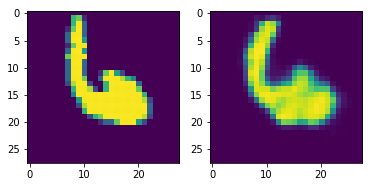

In [6]:
for data, _ in test_loader:
    plt.subplot(121)
    plt.imshow(data.view(-1, 28, 28).numpy()[0])
    _, _, x_p = vae.forward(data)
    plt.subplot(122)
    plt.imshow(x_p.data.view(-1, 28, 28).numpy()[0])
    break